MNIST 16x16 数据集加载器
使用增强版数据加载器（包含数据增强）...
下载MNIST数据集...

数据集信息:
  训练集大小: 60000
  测试集大小: 10000
  图像通道数: 1
  图像分辨率: 16x16

训练集类别分布:
  数字 0: 5923 张图片 (9.9%)
  数字 1: 6742 张图片 (11.2%)
  数字 2: 5958 张图片 (9.9%)
  数字 3: 6131 张图片 (10.2%)
  数字 4: 5842 张图片 (9.7%)
  数字 5: 5421 张图片 (9.0%)
  数字 6: 5918 张图片 (9.9%)
  数字 7: 6265 张图片 (10.4%)
  数字 8: 5851 张图片 (9.8%)
  数字 9: 5949 张图片 (9.9%)

测试集类别分布:
  数字 0: 980 张图片 (9.8%)
  数字 1: 1135 张图片 (11.4%)
  数字 2: 1032 张图片 (10.3%)
  数字 3: 1010 张图片 (10.1%)
  数字 4: 982 张图片 (9.8%)
  数字 5: 892 张图片 (8.9%)
  数字 6: 958 张图片 (9.6%)
  数字 7: 1028 张图片 (10.3%)
  数字 8: 974 张图片 (9.7%)
  数字 9: 1009 张图片 (10.1%)

训练集统计:
  批次大小: 64
  图像形状: torch.Size([1, 16, 16])
  像素均值: 0.1397
  像素标准差: 0.2744
  最小像素值: 0.0000
  最大像素值: 1.0000

测试集统计:
  批次大小: 64
  图像形状: torch.Size([1, 16, 16])
  像素均值: 0.1149
  像素标准差: 0.2433
  最小像素值: 0.0000
  最大像素值: 1.0000

可视化训练集样本 (灰度):


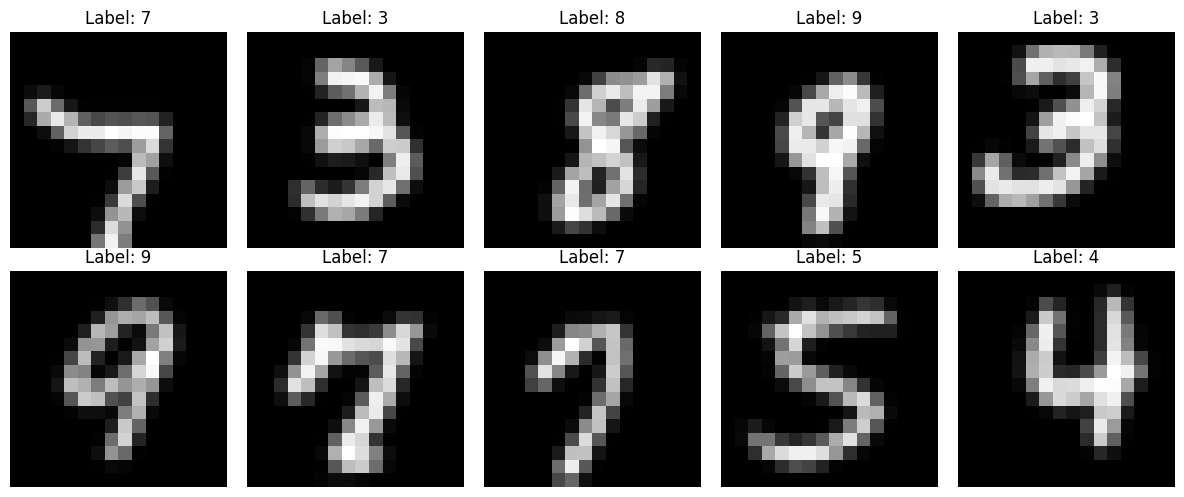


演示训练循环:
批次 1:
  数据形状: torch.Size([64, 1, 16, 16])
  目标形状: torch.Size([64])
批次 2:
  数据形状: torch.Size([64, 1, 16, 16])
  目标形状: torch.Size([64])
批次 3:
  数据形状: torch.Size([64, 1, 16, 16])
  目标形状: torch.Size([64])

数据集准备完成！可用于FlowMatch训练。


In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

def create_mnist_16x16_dataloaders(batch_size=128, data_dir='./data', as_rgb=False):
    """
    创建16x16分辨率的MNIST数据加载器

    参数:
        batch_size: 批次大小
        data_dir: 数据存储目录
        as_rgb: 是否转换为3通道RGB图像 (默认为单通道灰度图)
    """
    # 定义下采样变换
    if as_rgb:
        # 如果需要3通道，先将灰度图转换为RGB
        transform = transforms.Compose([
            transforms.Resize((16, 16)),
            transforms.Grayscale(num_output_channels=3),  # 转换为3通道
            transforms.ToTensor(),
        ])
    else:
        # 保持单通道灰度图
        transform = transforms.Compose([
            transforms.Resize((16, 16)),
            transforms.ToTensor(),
        ])

    # 下载训练集和测试集
    print("下载MNIST数据集...")
    trainset = torchvision.datasets.MNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=transform
    )

    testset = torchvision.datasets.MNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=transform
    )

    # 创建数据加载器
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

    # 显示数据集信息
    print(f"训练集大小: {len(trainset)}")
    print(f"测试集大小: {len(testset)}")

    # 检查一个批次的数据
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    print(f"图像形状: {images.shape}")
    print(f"标签形状: {labels.shape}")
    print(f"像素值范围: [{images.min():.3f}, {images.max():.3f}]")

    return trainloader, testloader, trainset, testset

def visualize_mnist_samples(dataset, num_samples=10, as_rgb=False):
    """可视化MNIST样本"""
    # 随机选择样本
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    # 创建子图
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        # 调整图像维度用于显示
        if as_rgb or img.shape[0] == 3:
            # 3通道图像: (C, H, W) -> (H, W, C)
            img_np = img.numpy().transpose(1, 2, 0)
        else:
            # 单通道图像: (1, H, W) -> (H, W)
            img_np = img.squeeze().numpy()

        ax = axes[i // 5, i % 5]
        if as_rgb or img.shape[0] == 3:
            ax.imshow(img_np)
        else:
            ax.imshow(img_np, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def check_class_distribution(dataset, dataset_name="数据集"):
    """检查类别分布"""
    # 收集所有标签
    all_labels = []
    for _, label in dataset:
        all_labels.append(label)

    all_labels = torch.tensor(all_labels)

    # 计算每个类别的数量
    unique, counts = torch.unique(all_labels, return_counts=True)

    print(f"\n{dataset_name}类别分布:")
    for cls, count in zip(unique, counts):
        print(f"  数字 {cls.item()}: {count} 张图片 ({count/len(dataset)*100:.1f}%)")

def display_data_statistics(loader, loader_name):
    """显示数据统计信息"""
    data_iter = iter(loader)
    images, labels = next(data_iter)

    print(f"\n{loader_name}统计:")
    print(f"  批次大小: {images.shape[0]}")
    print(f"  图像形状: {images.shape[1:]}")
    print(f"  像素均值: {images.mean():.4f}")
    print(f"  像素标准差: {images.std():.4f}")
    print(f"  最小像素值: {images.min():.4f}")
    print(f"  最大像素值: {images.max():.4f}")

# 增强版数据加载器，包含数据增强
def create_enhanced_mnist_dataloaders(batch_size=128, data_dir='./data', as_rgb=False, use_augmentation=True):
    """
    创建增强版的MNIST数据加载器，可选数据增强
    """
    # 基础变换
    base_transform = transforms.Compose([
        transforms.Resize((16, 16)),
    ])

    # 训练集变换（可选数据增强）
    if use_augmentation:
        train_transform = transforms.Compose([
            base_transform,
            transforms.RandomRotation(degrees=5),  # 轻微旋转
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # 轻微平移
            transforms.ToTensor(),
        ])
        if as_rgb:
            train_transform.transforms.insert(1, transforms.Grayscale(num_output_channels=3))
    else:
        train_transform = transforms.Compose([
            base_transform,
            transforms.ToTensor(),
        ])
        if as_rgb:
            train_transform.transforms.insert(1, transforms.Grayscale(num_output_channels=3))

    # 测试集变换（无数据增强）
    test_transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
    ])
    if as_rgb:
        test_transform.transforms.insert(1, transforms.Grayscale(num_output_channels=3))

    # 下载数据集
    print("下载MNIST数据集...")
    trainset = torchvision.datasets.MNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=train_transform
    )

    testset = torchvision.datasets.MNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=test_transform
    )

    # 创建数据加载器
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

    return trainloader, testloader, trainset, testset

if __name__ == "__main__":
    # 设置随机种子
    torch.manual_seed(42)
    np.random.seed(42)

    print("=" * 60)
    print("MNIST 16x16 数据集加载器")
    print("=" * 60)

    # 选择配置
    use_rgb = False  # 设为True如果你需要3通道图像
    use_augmentation = True  # 是否使用数据增强

    if use_augmentation:
        print("使用增强版数据加载器（包含数据增强）...")
        train_loader, test_loader, train_set, test_set = create_enhanced_mnist_dataloaders(
            batch_size=64,
            data_dir='./data',
            as_rgb=use_rgb,
            use_augmentation=use_augmentation
        )
    else:
        print("使用基础版数据加载器...")
        train_loader, test_loader, train_set, test_set = create_mnist_16x16_dataloaders(
            batch_size=64,
            data_dir='./data',
            as_rgb=use_rgb
        )

    # 检查数据集信息
    print(f"\n数据集信息:")
    print(f"  训练集大小: {len(train_set)}")
    print(f"  测试集大小: {len(test_set)}")
    print(f"  图像通道数: {train_set[0][0].shape[0]}")
    print(f"  图像分辨率: {train_set[0][0].shape[1]}x{train_set[0][0].shape[2]}")

    # 检查类别分布
    check_class_distribution(train_set, "训练集")
    check_class_distribution(test_set, "测试集")

    # 显示数据统计
    display_data_statistics(train_loader, "训练集")
    display_data_statistics(test_loader, "测试集")

    # 可视化样本
    print(f"\n可视化训练集样本 ({'RGB' if use_rgb else '灰度'}):")
    visualize_mnist_samples(train_set, num_samples=10, as_rgb=use_rgb)

    # 演示如何在训练循环中使用
    print("\n演示训练循环:")
    for batch_idx, (data, target) in enumerate(train_loader):
        print(f"批次 {batch_idx + 1}:")
        print(f"  数据形状: {data.shape}")  # (batch_size, channels, 16, 16)
        print(f"  目标形状: {target.shape}")  # (batch_size,)

        # 这里可以插入你的训练代码
        # 例如: output = model(data)
        #       loss = criterion(output, target)

        if batch_idx == 2:  # 只显示前3个批次
            break

    print("\n数据集准备完成！可用于FlowMatch训练。")

Loading MNIST dataset (16x16 resolution)...
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 8: 5851 samples

Creating visualizations...


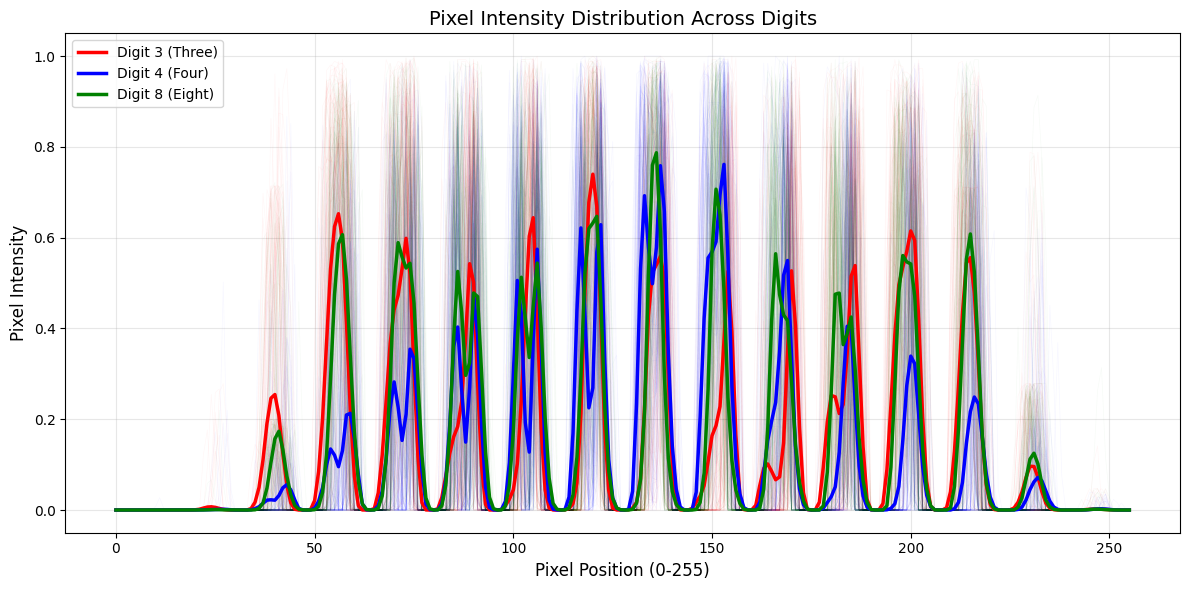


INTENSITY CURVE INTERPRETATION:
• Each faint line represents one handwritten digit sample
• Thick lines show the average pattern for each digit
• Differences in curves show how digits vary in pixel intensity patterns


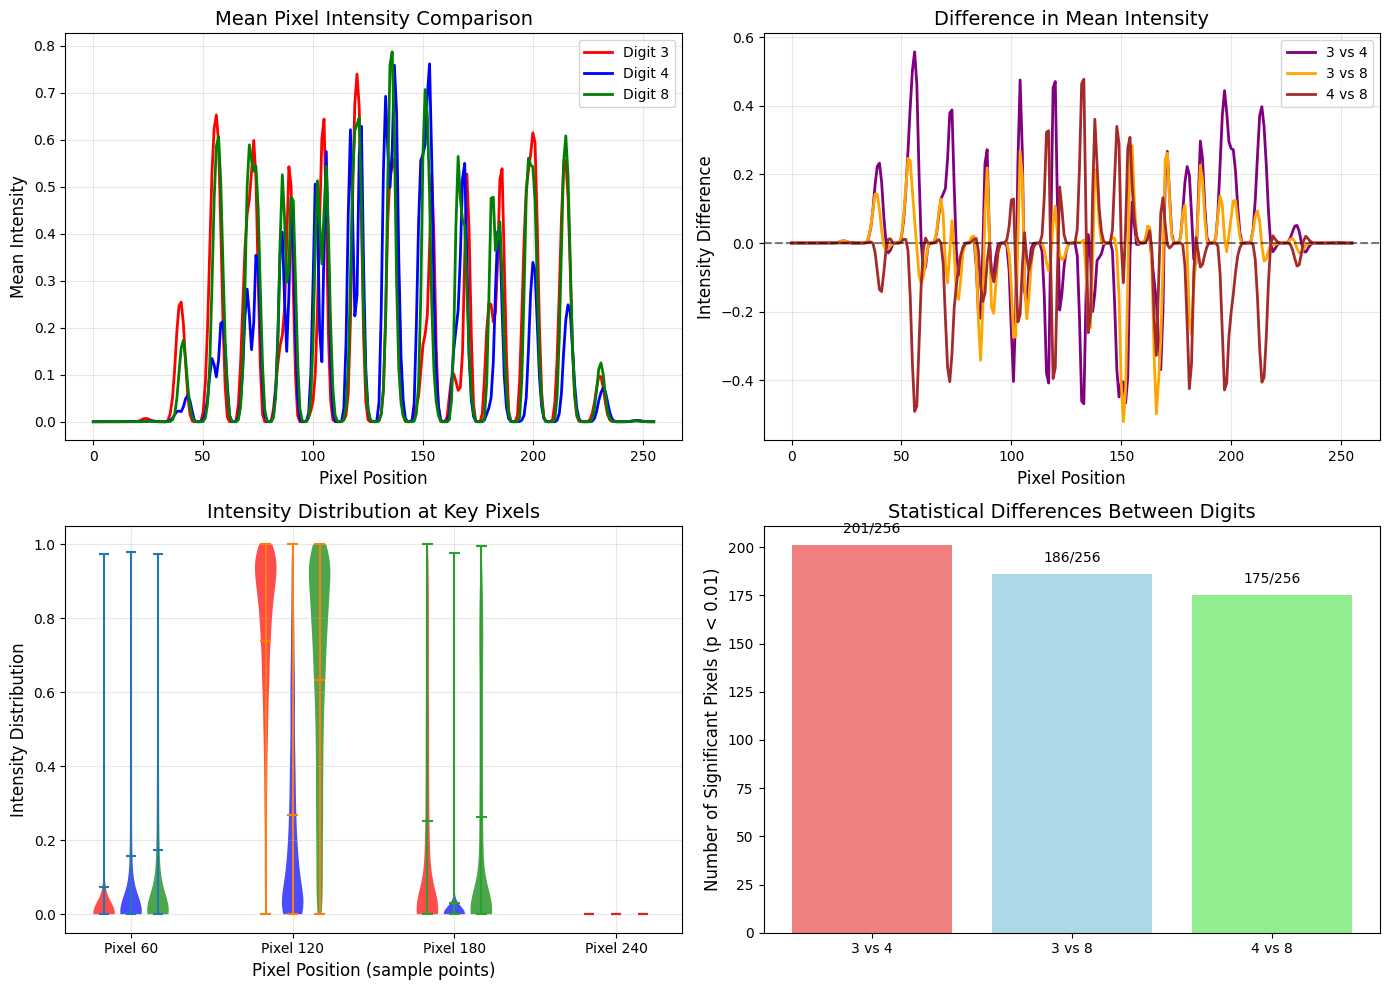


DIFFERENCE ANALYSIS:
1. Mean Intensity Curves:
   - Show the average 'shape' of each digit in pixel space
   - Peaks and valleys correspond to dark/light regions

2. Intensity Differences:
   - Positive values: Digit 3 has higher intensity at that pixel
   - Negative values: Compared digit has higher intensity

3. Distribution at Key Pixels:
   - Shows variability within each digit class
   - Wider distributions = more variation in handwriting

4. Statistical Significance:
   - Measures how distinct the digits are in pixel space
   - More significant pixels = easier to distinguish


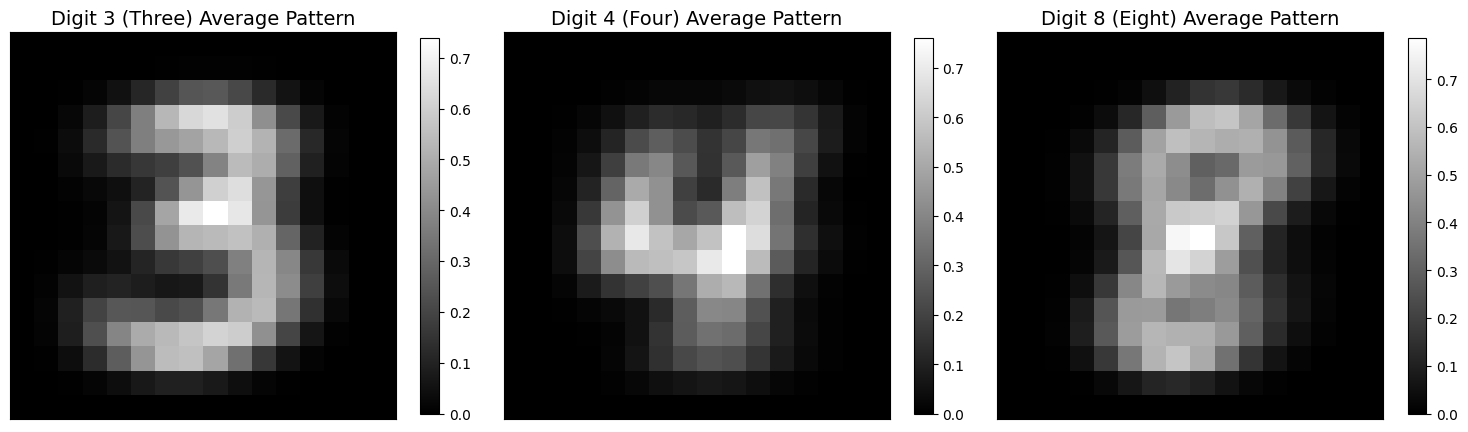


AVERAGE PATTERN INTERPRETATION:
• These images show what each digit typically looks like on average
• Bright areas: Commonly inked regions for that digit
• Dark areas: Rarely or never inked regions
• Differences in patterns explain why the intensity curves vary

SUMMARY STATISTICS:
Digit 3:
  Samples: 6131
  Mean intensity: 0.1420
  Intensity std: 0.2694
  Intensity range: [0.0000, 1.0000]
Digit 4:
  Samples: 5842
  Mean intensity: 0.1212
  Intensity std: 0.2527
  Intensity range: [0.0000, 1.0000]
Digit 8:
  Samples: 5851
  Mean intensity: 0.1503
  Intensity std: 0.2771
  Intensity range: [0.0000, 1.0000]


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from scipy import stats
import seaborn as sns

# Set global style for English labels and clean look
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

def load_mnist_16x16(data_dir='./data'):
    """Load MNIST dataset and resize to 16x16"""
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.MNIST(
        root=data_dir, train=True, download=True, transform=transform
    )

    return trainset

def extract_and_flatten_digits(dataset, digits):
    """Extract and flatten images for specified digits"""
    digit_data = {}

    for digit in digits:
        images = []
        for img, label in dataset:
            if label == digit:
                # Flatten image: (1, 16, 16) -> (256,)
                flat_img = img.flatten().numpy()
                images.append(flat_img)

        digit_data[digit] = np.array(images)
        print(f"Digit {digit}: {len(images)} samples")

    return digit_data

def plot_intensity_curves(digit_data, digits, n_samples=100):
    """Plot pixel intensity curves for each digit"""
    colors = ['red', 'blue', 'green']
    digit_names = {3: 'Three', 4: 'Four', 8: 'Eight'}

    plt.figure(figsize=(12, 6))

    # Plot individual samples (faint lines)
    for i, digit in enumerate(digits):
        if len(digit_data[digit]) > n_samples:
            indices = np.random.choice(len(digit_data[digit]), n_samples, replace=False)
        else:
            indices = np.arange(len(digit_data[digit]))

        for idx in indices:
            plt.plot(range(256), digit_data[digit][idx],
                    color=colors[i], alpha=0.03, linewidth=0.5)

    # Plot mean curves (bold lines)
    for i, digit in enumerate(digits):
        mean_curve = np.mean(digit_data[digit], axis=0)
        plt.plot(range(256), mean_curve, color=colors[i],
                linewidth=2.5, label=f'Digit {digit} ({digit_names[digit]})')

    plt.xlabel('Pixel Position (0-255)')
    plt.ylabel('Pixel Intensity')
    plt.title('Pixel Intensity Distribution Across Digits')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Explanation
    print("\nINTENSITY CURVE INTERPRETATION:")
    print("• Each faint line represents one handwritten digit sample")
    print("• Thick lines show the average pattern for each digit")
    print("• Differences in curves show how digits vary in pixel intensity patterns")

def plot_mean_comparison(digit_data, digits):
    """Compare mean intensity patterns between digits"""
    digit_names = {3: 'Three', 4: 'Four', 8: 'Eight'}
    colors = ['red', 'blue', 'green']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Mean intensity comparison
    for i, digit in enumerate(digits):
        mean_curve = np.mean(digit_data[digit], axis=0)
        axes[0, 0].plot(range(256), mean_curve, color=colors[i],
                       linewidth=2, label=f'Digit {digit}')

    axes[0, 0].set_xlabel('Pixel Position')
    axes[0, 0].set_ylabel('Mean Intensity')
    axes[0, 0].set_title('Mean Pixel Intensity Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Difference between digits
    mean_3 = np.mean(digit_data[3], axis=0)
    mean_4 = np.mean(digit_data[4], axis=0)
    mean_8 = np.mean(digit_data[8], axis=0)

    axes[0, 1].plot(range(256), mean_3 - mean_4, 'purple', linewidth=2, label='3 vs 4')
    axes[0, 1].plot(range(256), mean_3 - mean_8, 'orange', linewidth=2, label='3 vs 8')
    axes[0, 1].plot(range(256), mean_4 - mean_8, 'brown', linewidth=2, label='4 vs 8')

    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Pixel Position')
    axes[0, 1].set_ylabel('Intensity Difference')
    axes[0, 1].set_title('Difference in Mean Intensity')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Key pixel distributions
    key_pixels = [60, 120, 180, 240]  # Different regions of the image

    for i, pixel in enumerate(key_pixels):
        pixel_data = [digit_data[d][:, pixel] for d in digits]

        # Create violin plot for this pixel position
        vp = axes[1, 0].violinplot(pixel_data, positions=[pixel-10, pixel, pixel+10],
                                  widths=8, showmeans=True)

        # Color the violins
        for j, pc in enumerate(vp['bodies']):
            pc.set_facecolor(colors[j])
            pc.set_alpha(0.7)

    axes[1, 0].set_xlabel('Pixel Position (sample points)')
    axes[1, 0].set_ylabel('Intensity Distribution')
    axes[1, 0].set_title('Intensity Distribution at Key Pixels')
    axes[1, 0].set_xticks(key_pixels)
    axes[1, 0].set_xticklabels([f'Pixel {p}' for p in key_pixels])
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Statistical significance heatmap
    p_values_3vs4 = np.array([stats.ttest_ind(digit_data[3][:, i], digit_data[4][:, i]).pvalue
                             for i in range(256)])
    p_values_3vs8 = np.array([stats.ttest_ind(digit_data[3][:, i], digit_data[8][:, i]).pvalue
                             for i in range(256)])

    # Count significant pixels
    sig_3vs4 = np.sum(p_values_3vs4 < 0.01)
    sig_3vs8 = np.sum(p_values_3vs8 < 0.01)

    # Create simple bar chart
    comparisons = ['3 vs 4', '3 vs 8', '4 vs 8']
    sig_pixels = [sig_3vs4, sig_3vs8,
                  np.sum([stats.ttest_ind(digit_data[4][:, i], digit_data[8][:, i]).pvalue < 0.01
                         for i in range(256)])]

    bars = axes[1, 1].bar(comparisons, sig_pixels, color=['lightcoral', 'lightblue', 'lightgreen'])
    axes[1, 1].set_ylabel('Number of Significant Pixels (p < 0.01)')
    axes[1, 1].set_title('Statistical Differences Between Digits')

    # Add value labels on bars
    for bar, value in zip(bars, sig_pixels):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                       f'{value}/{256}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Explanation of differences
    print("\nDIFFERENCE ANALYSIS:")
    print("1. Mean Intensity Curves:")
    print("   - Show the average 'shape' of each digit in pixel space")
    print("   - Peaks and valleys correspond to dark/light regions")

    print("\n2. Intensity Differences:")
    print("   - Positive values: Digit 3 has higher intensity at that pixel")
    print("   - Negative values: Compared digit has higher intensity")

    print("\n3. Distribution at Key Pixels:")
    print("   - Shows variability within each digit class")
    print("   - Wider distributions = more variation in handwriting")

    print("\n4. Statistical Significance:")
    print("   - Measures how distinct the digits are in pixel space")
    print("   - More significant pixels = easier to distinguish")

def visualize_digit_patterns(digit_data, digits):
    """Visualize the average pattern of each digit as an image"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    digit_names = {3: 'Three', 4: 'Four', 8: 'Eight'}

    for i, digit in enumerate(digits):
        # Calculate mean image
        mean_img = np.mean(digit_data[digit], axis=0).reshape(16, 16)

        # Plot
        im = axes[i].imshow(mean_img, cmap='gray')
        axes[i].set_title(f'Digit {digit} ({digit_names[digit]}) Average Pattern')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

        # Add colorbar for each subplot
        plt.colorbar(im, ax=axes[i], shrink=0.8)

    plt.tight_layout()
    plt.show()

    # Explanation
    print("\nAVERAGE PATTERN INTERPRETATION:")
    print("• These images show what each digit typically looks like on average")
    print("• Bright areas: Commonly inked regions for that digit")
    print("• Dark areas: Rarely or never inked regions")
    print("• Differences in patterns explain why the intensity curves vary")

def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    print("Loading MNIST dataset (16x16 resolution)...")
    dataset = load_mnist_16x16()

    # Extract digits 3, 4, and 8
    digits = [3, 4, 8]
    digit_data = extract_and_flatten_digits(dataset, digits)

    # Create visualizations
    print("\nCreating visualizations...")

    # 1. Intensity curves
    plot_intensity_curves(digit_data, digits)

    # 2. Mean comparison and statistical analysis
    plot_mean_comparison(digit_data, digits)

    # 3. Average pattern visualization
    visualize_digit_patterns(digit_data, digits)

    # Summary statistics
    print("\nSUMMARY STATISTICS:")
    for digit in digits:
        data = digit_data[digit]
        print(f"Digit {digit}:")
        print(f"  Samples: {len(data)}")
        print(f"  Mean intensity: {np.mean(data):.4f}")
        print(f"  Intensity std: {np.std(data):.4f}")
        print(f"  Intensity range: [{np.min(data):.4f}, {np.max(data):.4f}]")

if __name__ == "__main__":
    main()